## Cumputer Vision
### Module 1. Image processing basics. Local image processing and feature descriptors

#### Task 1.2:      
     1. Pre-processing: Gaussian Blur
     2. FAST Detector
     3*. BRIEF Descriptor (optional)
    
    
by Anastasiia Kasprova

    Link to Google Colab: https://colab.research.google.com/drive/1soEHajo0zmejsodVjkhXSG5ed4i0l5Ez
    Link to github: https://github.com/kasprova/CV_UCU/tree/master/module1

Link to Google Colab: https://colab.research.google.com/drive/1soEHajo0zmejsodVjkhXSG5ed4i0l5Ez

In [0]:
import cv2
import numpy as np
import sys
from skimage import io
from numpy.linalg import inv
from google.colab.patches import cv2_imshow
np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

In [0]:
#! pip install opencv-python==4.1.0.25

In [0]:
#from url to image
def url_to_image(url):
  print("downloading %s" % (url))
  return io.imread(url)

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_0.png


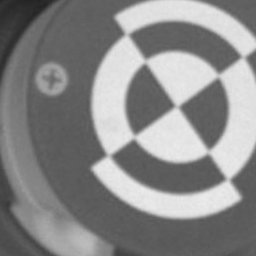

In [60]:
url = "https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_0.png"
img = url_to_image(url)
cv2_imshow(img)

### 1.1. Pre-processing: Gaussian Blur using Numpy

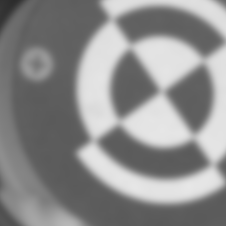

In [61]:
#Gaussian kernel
def gaussian_2d_kernel(size, sigma=1):
    """
    Input: size - size of kernel
           sigma - sigma:)
    Output: 2D Gaussian array
        (size x size kernel with Gaussian distribution defined by sigma value)
         g(x,y) = 1/(2*PI*sigma^2) * exp(-(x^2+y^2)/(2*sigma^2))
    """
    r = int(size) // 2 #half-size ~ radius
    x, y = np.meshgrid(np.linspace(-r,r,size), np.linspace(-r,r,size))
    g = 1 / (2.0 * np.pi * sigma**2) * np.exp(-((x**2 + y**2) / (2.0*sigma**2)))
    g = g.astype(np.float32)
    
    return g

  
#Convolution 
def convolution_2d(img, kernel, stride = 1):
    """
    Convolve two 2-dimensional arrays
    Assumptions: 
        - no paddding, 
        - stride is the same for horizontal and vertical movings 
    Returns: 
        2d array containing a subset ot the discrete linear convolution of img and kernel
    """
    if not img.ndim == kernel.ndim == 2:
        raise ValueError('convolution_2d inputs must both be 2D arrays')
    
    img_h, img_w = img.shape
    kernel_h, kernel_w = kernel.shape
    stride = np.int32(stride)
    
    #output_hight = (img_hight - filter_hight)/stride +1
    conv_output_h = np.int32((img_h - kernel_h)/stride + 1)
    #output_width = (img_width - filter_width)/stride +1
    conv_output_w = np.int32((img_w - kernel_w)/stride + 1)
    conv_output = np.zeros((conv_output_h,conv_output_w), dtype=np.int32)
    
    
    #convolution
    for i, row in enumerate(conv_output):
        for j, pixel in enumerate(row):
            conv_output[i][j] = np.sum(img[i:i+kernel_h, j:j+kernel_w]*kernel)
    
    return conv_output 
  
def gaussian_blur(img, size, sigma):
    """
    Input:
        img - numpy 2d array
        size - N int - corresponding to NxN array
        sigma - sigma
    Output: convolution_output - gaussian blured image - numpy 2d array       
    
    """
    #assigning value to kernel
    kernel = gaussian_2d_kernel(size, sigma)
    
    #convolution output
    convolution_output = convolution_2d(img = img, kernel = kernel)
    
    return convolution_output

  
#visualization of result
cv2_imshow(gaussian_blur(img, 31, 3))

### 1.2 Feature Detection: FAST (a high-speed test) using Numpy

#### Algorithm:

1. Select a pixel p in the image which is to be identified as an interest point or not. Let its intensity be I_p.
2. Select appropriate threshold value t.
3. Consider a circle of 16 pixels around the pixel under test. (See the image below)
4. Now the pixel p is a corner if there exists a set of n contiguous pixels in the circle (of 16 pixels) which are all brighter than I_p + t, or all darker than I_p − t. (Shown as white dash lines in the above image). n was chosen to be 12.
5. A high-speed test was proposed to exclude a large number of non-corners. This test examines only the four pixels at 1, 9, 5 and 13 (First 1 and 9 are tested if they are too brighter or darker. If so, then checks 5 and 13). If p is a corner, then at least three of these must all be brighter than I_p + t or darker than I_p − t. If neither of these is the case, then p cannot be a corner. The full segment test criterion can then be applied to the passed candidates by examining all pixels in the circle

In [0]:
#circle around pixel
def circle_points_location(i,j):
    """
    Input: y,x coordinates (here i,j) of pixel location
    Output: dictionay of 16 points on the circle with radius = 3 around the given pixel p 
        having the following structure:
            {1:[i1,j1], 2:[i2,j2], ... , 16:{i16,j16}
    
    Ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_fast/py_fast.html
    
    """
    point_1 = (i-3,j)
    point_2 = (i-3,j+1)
    point_3 = (i-2,j+2)
    point_4 = (i-1,j+3)
    point_5 = (i,j+3)
    point_6 = (i+1,j+3)
    point_7 = (i+2,j+2)
    point_8 = (i+3,j+1)
    point_9 = (i+3,j)
    point_10 = (i+3,j-1)
    point_11 = (i+2,j-2)
    point_12 = (i+1,j-3)
    point_13 = (i,j-3)
    point_14 = (i-1,j-3)
    point_15 = (i-2,j-2)
    point_16 = (i-1,j-3)
    
    dictionary_of_points = {}
    list_of_points_coordinates = [point_1,point_2, point_3, point_4, point_5, point_6, point_7, point_8, point_9, point_10, point_11, point_12, point_13, point_14, point_15,point_16]

    for index,i in enumerate (range(1,17)):
        dictionary_of_points[i] =  list_of_points_coordinates[index]
    
    return dictionary_of_points

#FAST high-speed test realization
def fast_high_speed_corner_detection(img, i_padding = 3, j_padding = 3, threshold = 20):
    """
    Input: img - grey image
           i_padding - starting point where to search for corner - row number (y-coordinate)
           j_padding - starting point where to search for corner - column number (x-coordinate)
           threshold - delta of brightnes between pixel p and point on the circle with diameter of 7
    Output: list of tuples with (j,i) coordinates (x,y) - position of detected cornes
            having the following structure:
            [(j1,i1), (j2,i2), ..., (jn,in)]
    Algorithm details: 
        This examines only the four pixels at 1, 9, 5 and 13 
        First 1 and 9 are tested if they are too brighter or darker. 
        If so, then checks 5 and 13). If p is a corner, 
        then at least three of these must all be brighter 
        than I_p + t or darker than I_p − t. 
        If neither of these is the case, then p cannot be a corner.
           
    """

    list_of_corners = []
    for i in range(i_padding, img.shape[0]-i_padding):
        for j in range(j_padding, img.shape[1]-j_padding):
            #coordinates of the circle with d = 7 around the given pixel p 
            fast_circle_points = circle_points_location(i,j)
            #check intensity among p and points 1 and 9
            if ((img[i,j]+threshold)<img[fast_circle_points[1]] and (img[i,j]+threshold)<img[fast_circle_points[9]]) or ((img[i,j]-threshold)>img[fast_circle_points[1]] and (img[i,j]-threshold)>img[fast_circle_points[9]]):
                #check intensity among p and points 5 and 13
                if ((img[i,j]+threshold)<img[fast_circle_points[1]]  and ((img[i,j]+threshold)<img[fast_circle_points[5]] or (img[i,j]+threshold)<img[fast_circle_points[13]])) or ((img[i,j]-threshold)>img[fast_circle_points[1]]  and ((img[i,j]-threshold)>img[fast_circle_points[5]] or (img[i,j]-threshold)>img[fast_circle_points[13]])):
                    #pixel p is a corner
                    list_of_corners.append((j,i))
    return list_of_corners


#visualization of the detected corners
def plot_corners_on_image(img, list_of_corners):
    """
    Input:
        img - image in grey scale
        list_of_corners - list of coordinates (tuples) where corners where detected
            having the following structure:
            [(j1,i1), (j2,i2), ..., (jn,in)]
    Output: image with red dots representing the location of corners
    
    """
    for corner_coordinates in list_of_corners:
        cv2.circle(img,corner_coordinates, radius = 3, color = (255,0,0))
    img_with_found_corners = img[:]
    
    return img_with_found_corners

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_0.png
Detected key points on the original image:  [(113, 17), (114, 17), (115, 17), (116, 17), (117, 17), (118, 17), (115, 18), (116, 18), (120, 32), (121, 32), (122, 32), (121, 33), (122, 33), (123, 33), (124, 33), (122, 34), (123, 34), (124, 34), (129, 34), (130, 34), (129, 35), (130, 35), (131, 35), (132, 35), (133, 35), (134, 35), (129, 36), (130, 36), (131, 36), (132, 36), (133, 36), (238, 55), (239, 55), (237, 56), (238, 56), (239, 56), (240, 56), (241, 56), (238, 57), (239, 57), (240, 57), (241, 57), (245, 58), (246, 58), (247, 58), (248, 58), (247, 59), (248, 59), (141, 60), (142, 60), (143, 60), (133, 61), (142, 61), (143, 61), (148, 61), (148, 62), (149, 62), (150, 62), (55, 71), (56, 71), (61, 72), (55, 74), (56, 74), (214, 74), (215, 74), (216, 74), (214, 75), (215, 75), (215, 76), (220, 76), (221, 76), (222, 76), (42, 77), (43, 77), (44, 77), (222, 77), (45, 78), (47, 79), (53

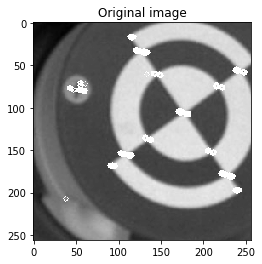

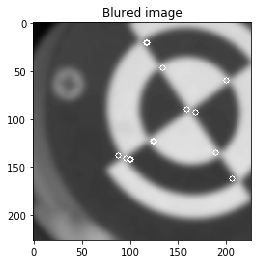

In [73]:
url = "https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_0.png"
#original image
img = url_to_image(url)

#applied gaussian blur
img_blur = gaussian_blur(img, 31, 3)

#detect corners for original image
list_of_corners = fast_high_speed_corner_detection(img, i_padding = 3, j_padding = 3, threshold = 10)

#detect corners for blured image
list_of_corners_blur = fast_high_speed_corner_detection(img_blur, i_padding = 3, j_padding = 3, threshold = 10)



#visualization
plt.figure(1)
plt.imshow(plot_corners_on_image(img,list_of_corners), cmap="gray"); plt.title("Original image")
print("Detected key points on the original image: ", list_of_corners)

plt.figure(2)
plt.imshow(plot_corners_on_image(img_blur,list_of_corners_blur), cmap="gray"); plt.title("Blured image")
print("Detected key points on the blured image: ", list_of_corners_blur)

plt.show()

**Comments**: Although I had an attempt to calculate descriptors detect_keypoints_and_calculate_descriptors using shown above numpy based Gaussian Blur and fast-speed BRIEF functions, it is was not successfully, since orb.compute() wants special cv2 key points representation (cv_kp_arr)

--------

In [0]:
#cv2_imshow(img)
#cv2_imshow(cv2.GaussianBlur(img, (31, 31), 3.0))
#cv2_imshow(img_blur)

### 2. Open CV realization

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_0.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_1.png


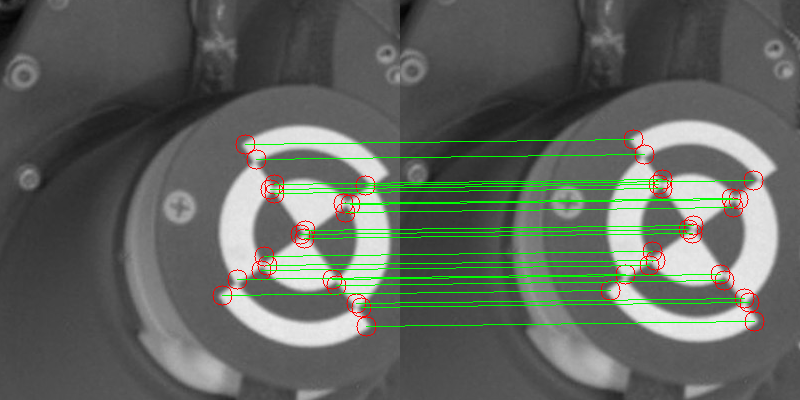

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_1.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_2.png


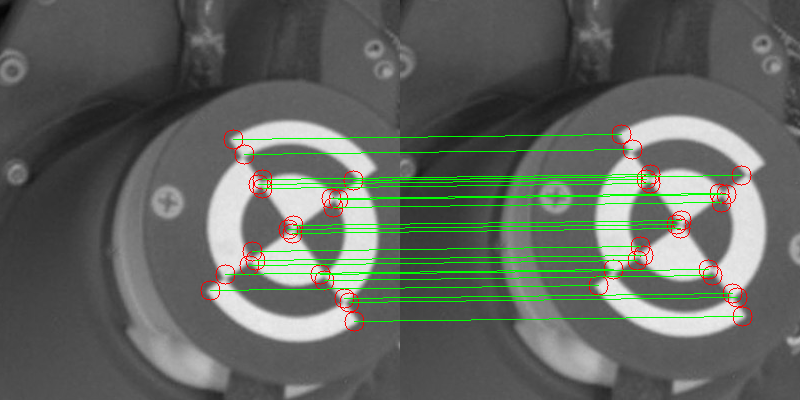

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_2.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_3.png


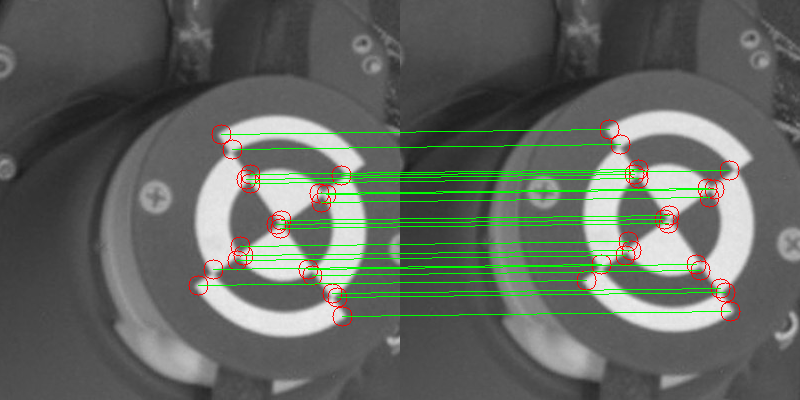

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_3.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_4.png


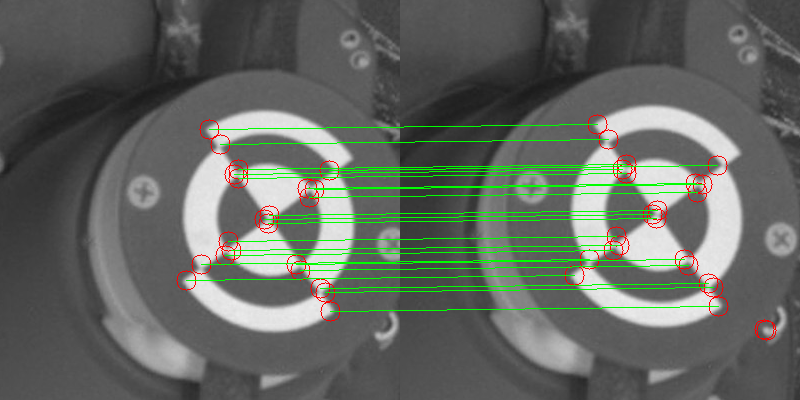

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_4.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_5.png


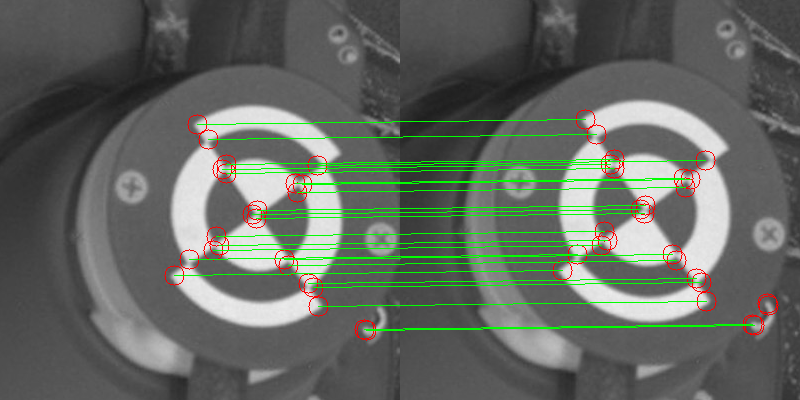

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_5.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_6.png


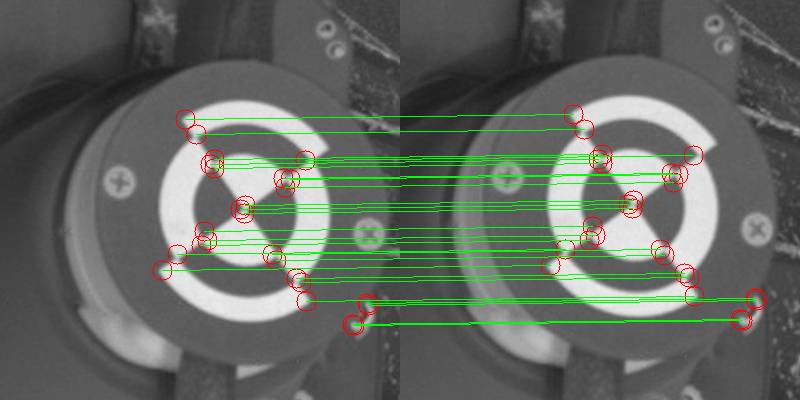

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_6.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_7.png


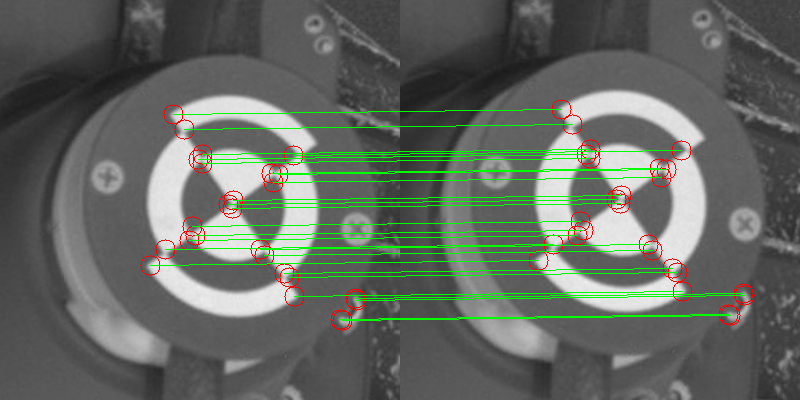

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_7.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_8.png


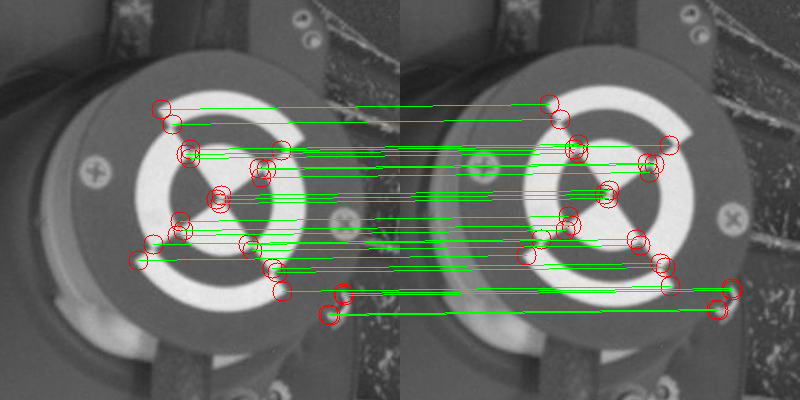

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_8.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_9.png


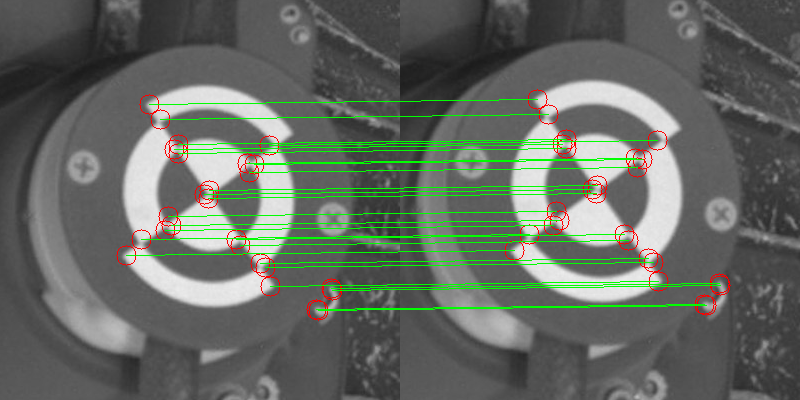

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_0.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_1.png


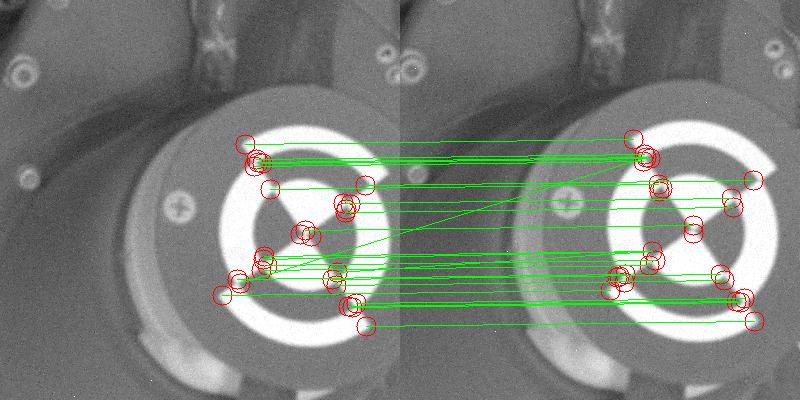

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_1.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_2.png


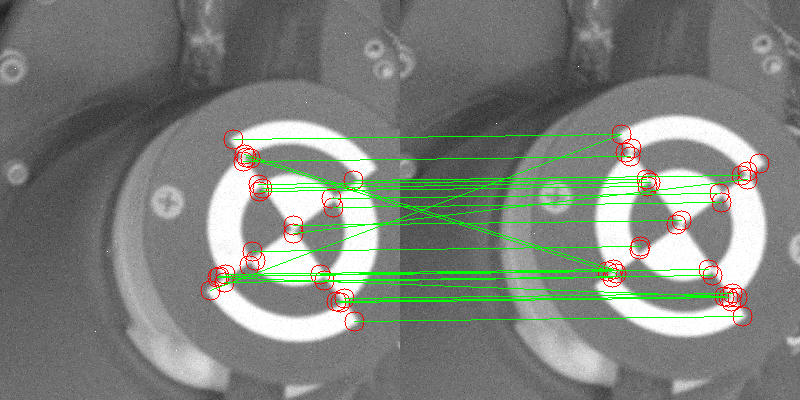

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_2.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_3.png


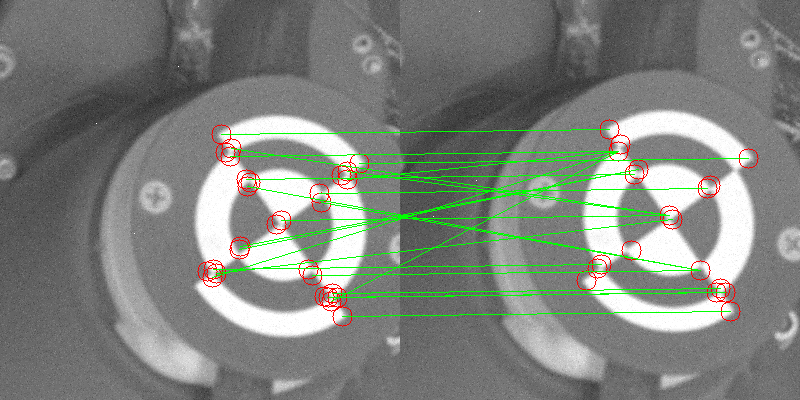

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_3.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_4.png


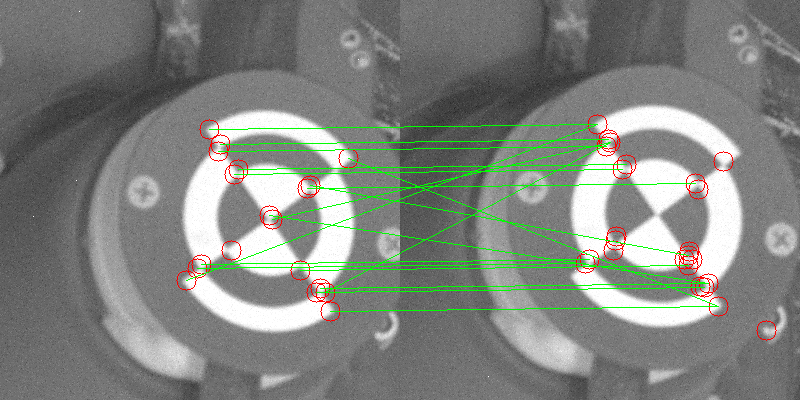

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_4.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_5.png


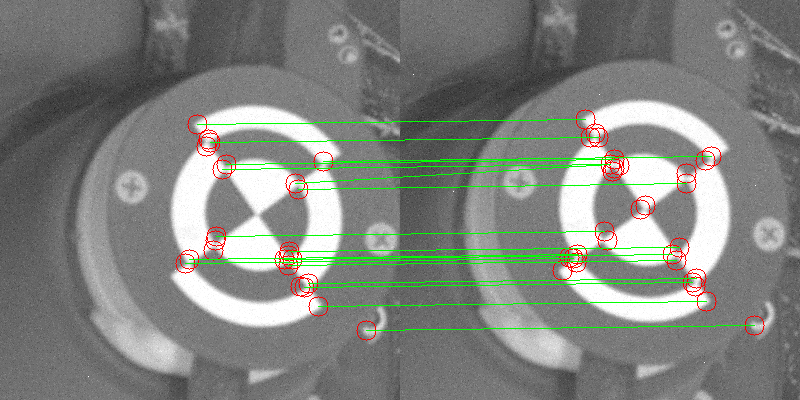

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_5.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_6.png


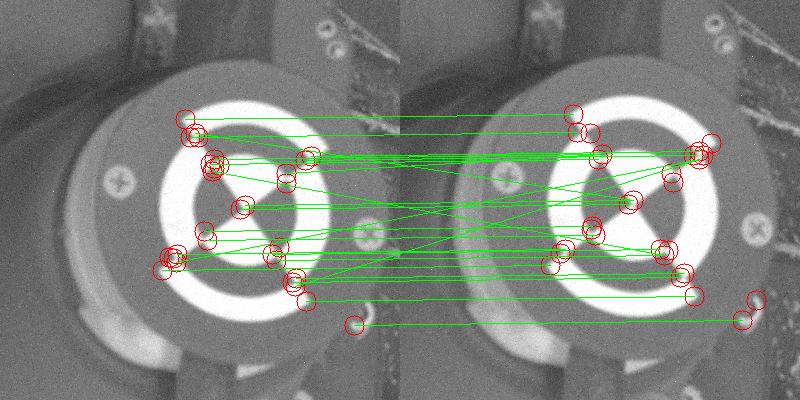

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_6.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_7.png


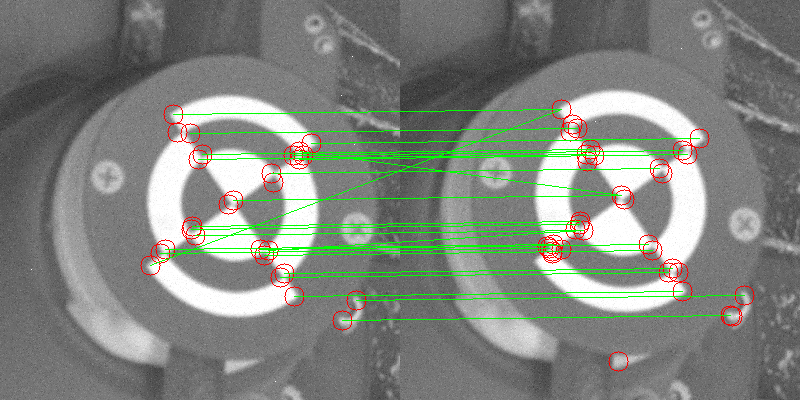

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_7.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_8.png


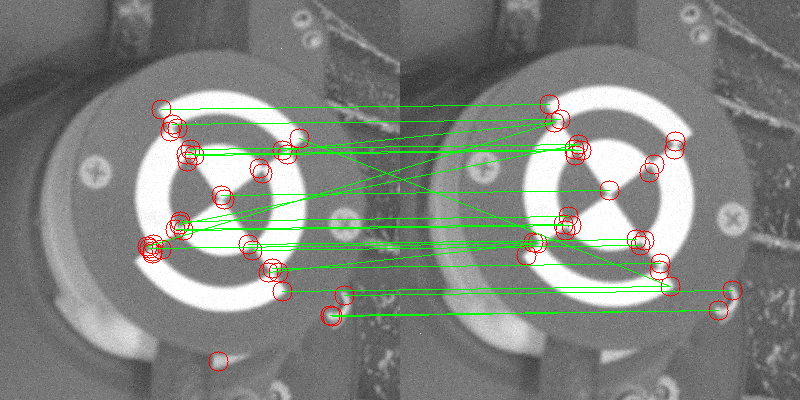

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_8.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/translation_noise_9.png


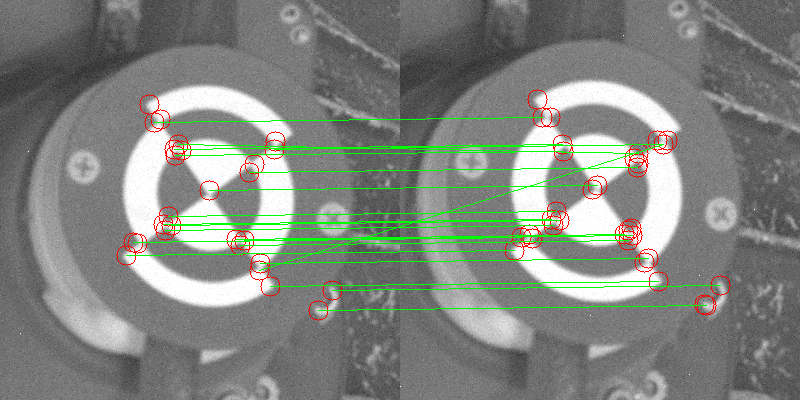

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_0.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_1.png


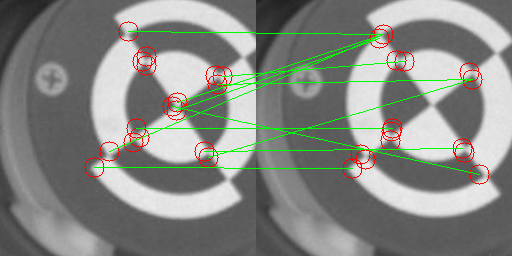

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_1.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_2.png


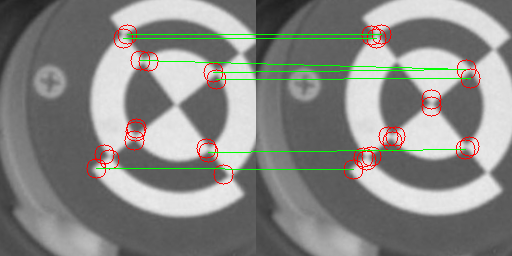

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_2.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_3.png


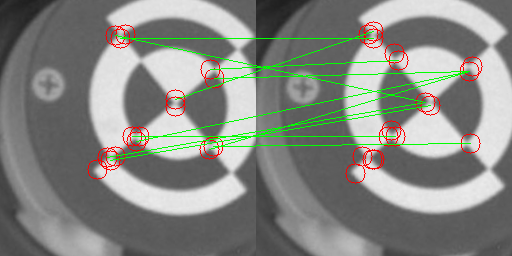

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_3.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_4.png


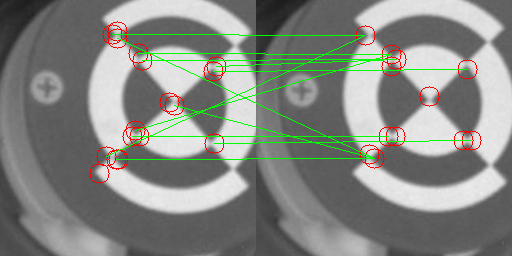

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_4.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_5.png


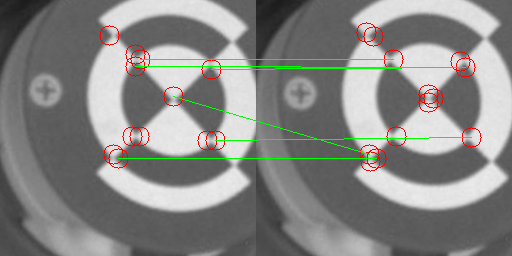

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_5.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_6.png


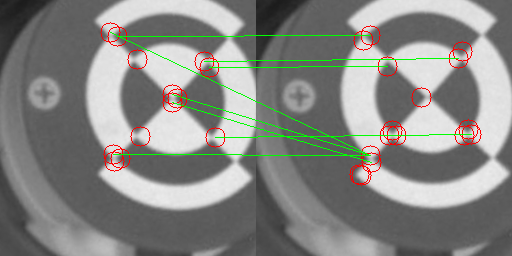

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_6.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_7.png


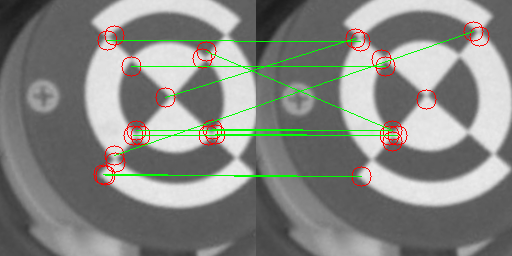

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_7.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_8.png


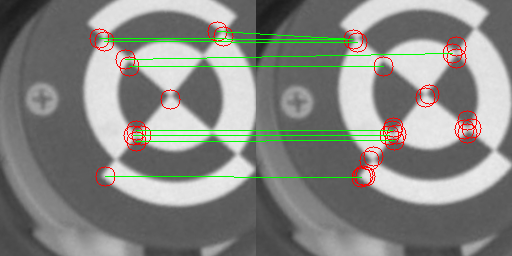

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_8.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_2_9.png


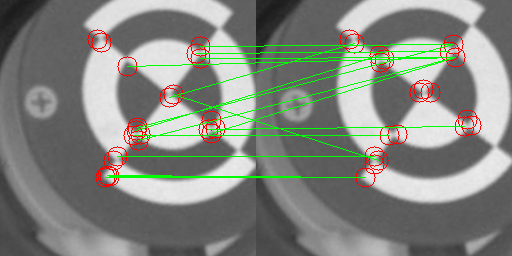

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_0.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_1.png


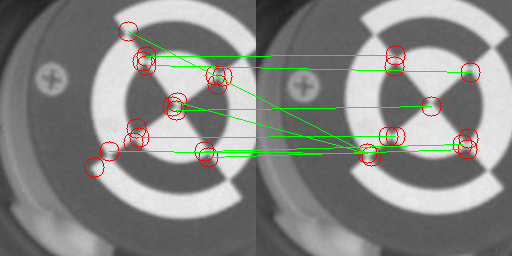

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_1.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_2.png


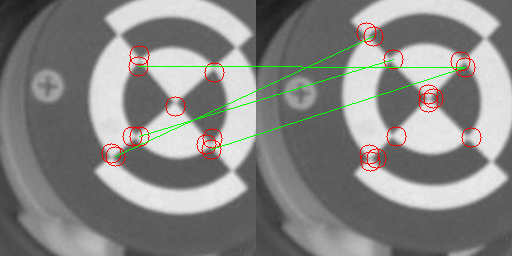

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_2.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_3.png


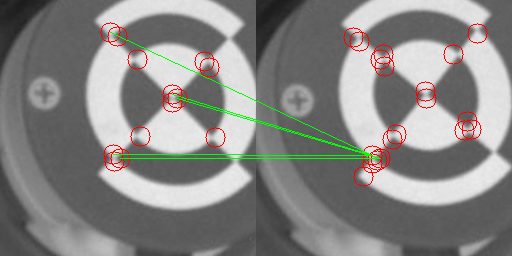

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_3.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_4.png


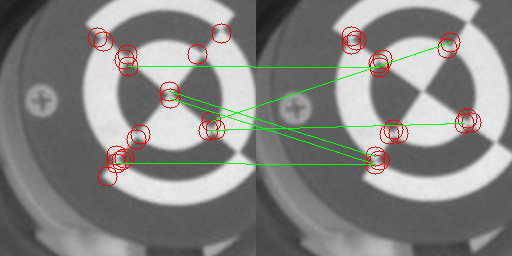

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_4.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_5.png


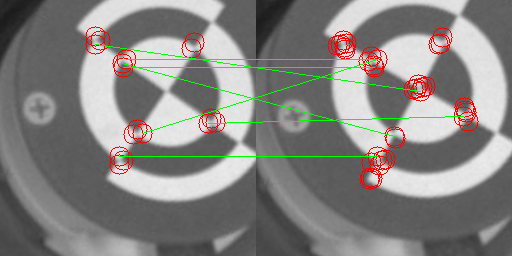

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_5.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_6.png


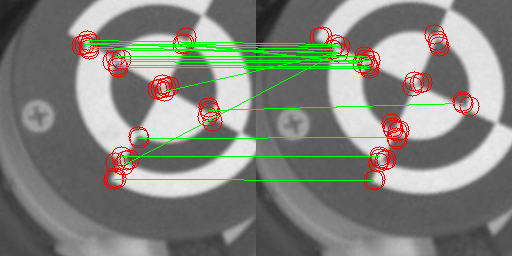

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_6.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_7.png


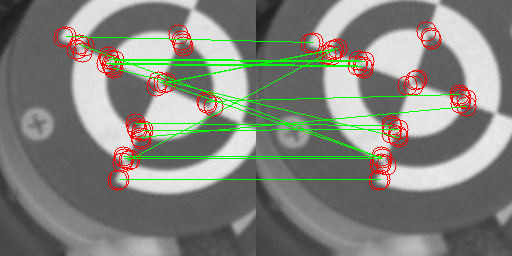

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_7.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_8.png


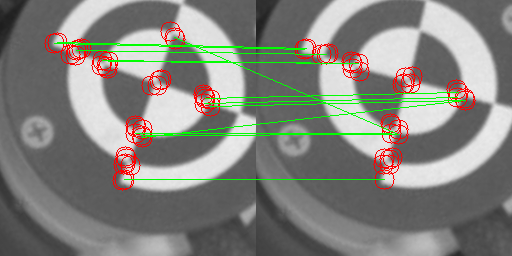

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_8.png
downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/rotation_5_9.png


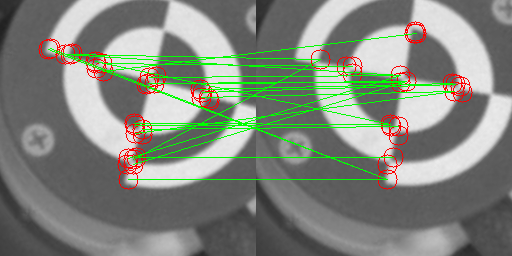

In [25]:
#path to folder with images
img_in_path = 'https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/tracking/'

#initialization of FAST and ORB
fast = cv2.FastFeatureDetector_create()
orb = cv2.ORB_create()


# function for keypoints and descriptors calculation
def detect_keypoints_and_calculate_descriptors(img):
    """
    Input: img - numpy 2d array (grayscale image)
    Output: kp_arr, cv_descr_arr
      kp_arr - is array of 2d coordinates-tuples (dectected corners with detector), 
         having the following structure
         [(x0, y0), (x1, y1), ...]
         xN, yN - integers
      cv_descr_arr - is array of descriptors (arrays),
          having the following structure
         [[v00, v01, v02, ...], [v10, v11, v12, ...], ...]
         vNM - floats
      
    """
    # applying Gaussian filter with the size 31x31 and sigma=3
    img_blur = cv2.GaussianBlur(img, (31, 31), 3.0)

    #detect corners/key points with FAST detector
    cv_kp_arr = fast.detect(img_blur, None)

    #calculate descriptors for key points
    cv_kp_arr, cv_descr_arr = orb.compute(img_blur, cv_kp_arr)

    # keypoints
    kp_arr = []
    for i in range(len(cv_kp_arr)):
        kp_arr.append((
            int(cv_kp_arr[i].pt[0]),
            int(cv_kp_arr[i].pt[1])
        ))
        
    return kp_arr, cv_descr_arr
  

def match_brute_force(descr_arr0, descr_arr1):
    """
    Brute-Force matcher takes descriptor of the feature in the first set and 
    is matched with all other feature in the 2nd set using some distance calculation.
    For BRIEF, ORB - use NORM_HAMMING - hamming distance as a measurement
    
    Input:
        descr_arr0 - array of descriptors of the 1st image
        descr_arr1 - array of descriptors of the 2nd image
    Output:
        matches_arr - array with matching points
    
    """
  
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    # return 2 matches for keypoint
    matches = bf.knnMatch(descr_arr0, descr_arr1, k=2)

    matches_arr = []
    for match_a, match_b in matches:
        # mark match good if 2nd match has bigger distance
        # (filtering similar keypoints)
        if match_a.distance < 0.75 * match_b.distance:
            matches_arr.append((
                match_a.queryIdx,
                match_a.trainIdx
            ))

    return matches_arr


for test_name in ['translation_', 'translation_noise_', 'rotation_2_', 'rotation_5_']:
    for frame_idx in range(9):

        # read two frames
        img0_fpath = img_in_path + test_name + str(frame_idx) + '.png'
        #img0 = cv2.imread(img0_fpath, cv2.IMREAD_GRAYSCALE) #jupyter
        img0 = url_to_image(img0_fpath) #colab

        img1_fpath = img_in_path + test_name + str(frame_idx+1) + '.png'
        #img1 = cv2.imread(img1_fpath, cv2.IMREAD_GRAYSCALE) #jupyter
        img1 = url_to_image(img1_fpath) #colab
        
        rows, cols = img0.shape

        # detect keypoints and calculate descriptors
        kp0, descr0 = detect_keypoints_and_calculate_descriptors(img0.copy())
        kp1, descr1 = detect_keypoints_and_calculate_descriptors(img1.copy())

        # match
        match_arr = match_brute_force(descr0, descr1)

        # draw on one image
        img_both = np.zeros((rows, cols*2), np.uint8)
        img_both[:, 0:cols] = img0
        img_both[:, cols:cols*2] = img1
        img_both_bgr = cv2.cvtColor(img_both, cv2.COLOR_GRAY2BGR)

        # keypoints as red circles
        for i in range(len(kp0)):
            kp = kp0[i]
            x = kp[0]
            y = kp[1]
            cv2.circle(img_both_bgr, (x, y), 10, (0, 0, 255))

        for i in range(len(kp1)):
            kp = kp1[i]
            x = kp[0] + cols
            y = kp[1]
            cv2.circle(img_both_bgr, (x, y), 10, (0, 0, 255))

        # matches as green lines
        for pair in match_arr:
            x0 = kp0[pair[0]][0]
            y0 = kp0[pair[0]][1]
            x1 = kp1[pair[1]][0] + cols
            y1 = kp1[pair[1]][1]
            cv2.line(img_both_bgr, (x0, y0), (x1, y1), (0, 255, 0))

        # show
        #plt.imshow(img_both_bgr) #jupyter inline image
        #plt.show()
        
        #cv2.imshow('img_both', img_both_bgr) #jupyter separate windows
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
        
        cv2_imshow(img_both_bgr) #colab

#### Reference:
   1. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_fast/py_fast.html
   2. https://www.researchgate.net/publication/223831601_Fast_Corner_Detection
   3. https://www.cs.ubc.ca/~lowe/525/papers/calonder_eccv10.pdf
   4. https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_brief/py_brief.html
   5. https://github.com/felistrs/ucu-cv-code/tree/master/homework2